Notebook réalisé avec la participation de Reda CHHAIBI, Emilio PICARD, à l'aide de données fournies par David ROUSSEL. \
31/08/2023, Louis CARLIER

In [ ]:
# import des bibliothèques

import numpy as np
import matplotlib.pyplot as plt

# Toilettage des données

Notre donnée d'étude est un *data frame* d'entrée de type série temporelle $X \in \mathbb R^{d \times T}$. Nous avons également un *data frame* scalaire de sortie $Y \in \mathbb R^T$. \\
Par exemple la mesure successive au cours du temps de différents capteurs numériques ou booléens installés sur un avion en vol, dont une grandeur d'intérêt difficile à mesurer et que l'on cherche à prédire.

In [ ]:
import pandas as pd

pd_X_train = pd.read_csv ('X_train_liftoff.csv', sep=";")
pd_Y_train = pd.read_csv ('y_train_liftoff.csv', sep=";")

# Numpy conversion
X_train = pd_X_train.to_numpy()
X_train[:,0] = 1 # temps <- constante (régression affine)
Y_train = pd_Y_train.to_numpy()[:,1:].squeeze() #temps <-

# Print dimensions
print( "Factors dim:", X_train.shape )
print( "Output  dim:", Y_train.shape )
factor_count = X_train.shape

Factors dim: (58262, 33)
Output  dim: (58262,)


In [ ]:
d = X_train.shape[1]

Il faut toiletter un peu le *data frame* à cause du bruit dû à l'incertitude des mesures. Pour cela on va le passer dans un filtre de moyenne mobile afin de lisser le bruit. \\
On a donc besoin de trouver sur quelle échelle de temps $h$ effectuer le lissage. Pour cela on effectue un autocorrélogramme : \\
$\rho (h) = \dfrac{\mathbb Cov [X_t,X_{t+h}]}{\mathbb V(X_t)}$ sous l'hypothèse de stationnarité.

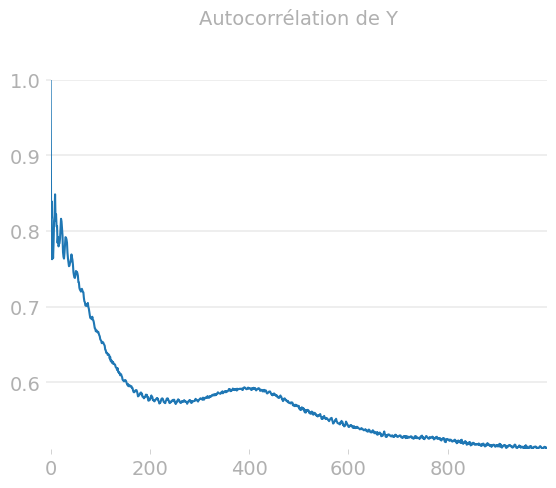

In [ ]:
import statsmodels.api as sm

lags = range(1000)
acorr = sm.tsa.acf( Y_train, nlags = len(lags)-1 )

plt.plot(acorr)
plt.title('Autocorrélation de Y')
plt.show()

In [ ]:
h = 200

In [ ]:
# lissage par moyenne mobile

kernel = np.ones( (h,))/h
X_conv_list = []
for i in range( X_train.shape[1]):
    convolved = np.convolve( X_train[:,i].squeeze() , kernel, 'valid')
    X_conv_list.append( convolved)
X_train = np.array( X_conv_list ).T
Y_train = np.convolve( Y_train, kernel , 'valid')

print( X_train.shape, Y_train.shape)

(58063, 33) (58063,)


In [ ]:
T = X_train.shape[0]

# Signatures

La signature de $X$ entre $s$ et $t$ à l'ordre $k \ge 0$ est définie comme $$S(X)_{s,t}^k : = \underset{s<u_1<\dots<u_k<t} {\int \dots \int} dX_{u_1} \otimes \dots \otimes dX_{u_k} \in \big({\mathbb R^d}\big)^{\otimes k},$$
pourvu que $X$ soit de variation bornée, ce qui est le cas pour de signaux physiques (continus) ou booléens (sautant une finitude fois).

Puis la signature de $X$ entre $s$ et $t$ est $$S(X)_{s,t}:=(S(X)_{s,t}^k)_{k\ge 0} \in T((\mathbb R^d)).$$

# Calcul de la signature

## Modules déjà existants

Trois modules existent déjà, tous développés sous la houlette du professeur Terry Lyons.

*   *esig* (Benjamin Graham, 2017)
*   *iisignature* (Jeremy Reizenstein, 2018)
*   *signatory* (Patrick Kidger, 2020), **parallélisable**

J'ai voulu développer mon propre algorithme, avec comme objectif de performance le même ordre de grandeur qu'*esig*.



## Mon module

Le chemin $X$ est continué par son affine par morceaux  : $$X_{|[s,t]}=\overrightarrow{X_sX_{s+1}} * \dots * \overrightarrow{X_{t-1}X_t}.$$
On utilise la relation de Chen $S(Y*Z)=S(Y)\otimes S(Z)$ pour calculer la signature de $X_{|[s,t]}$ :
 $$S(X)_{s,t}=S(\overrightarrow{X_sX_{s+1}})\otimes \dots \otimes S(\overrightarrow{X_{t-1}X_{t}}).$$
 Or $S(\overrightarrow{X_iX_{i+1}})=\exp (X_{i+1}-X_i)$.

In [ ]:
# calcul de l'exponentielle du vecteur x, tronquée à la profondeur depth

def exp(x, depth):
    e=[np.array([1])]
    for j in range(depth):
        e.append((np.tensordot(e[j], x/(j+1), axes=0)).squeeze())
    return e

J'ai ensuite besoin de coder l'opération $\otimes$ dans l'algèbre tensorielle qui n'est pas native en *numpy* ou *PyTorch*.

In [ ]:
# multiplication tensorielle tronquée à l'ordre <=depth

def tensor(x, y, depth):
    d=x[1].shape[0]
    n=len(x)-1
    m=len(y)-1
    prod=[]
    for i in range(min(n+m+1,depth)):
        if i > 0 :
            shape=tuple([d for j in range(i)])
        else :
            shape=(1,)
        s=np.zeros(shape)
        for j in range(i+1):
            if j <= n and (i-j) <= m :
                s+=np.tensordot(x[j], y[i-j], axes=0).squeeze() # produit de convolution
        prod.append(s)
    return prod

In [ ]:
# signature de X, tronquée à la profondeur depth

def signature(X, depth):
    T=X.shape[0]
    D=X[1:]-X[:-1] #incréments de X
    S=exp(D[0], depth)
    for j in range(1, T-1):
        S=tensor(S, exp(D[j], depth), depth)
    return S

In [ ]:
# flattening standard des séries tensorielles pour pouvoir comparer aux modules

def unstack(tensor):
    unstacked_tensor=[]
    for i in range(len(tensor)):
        unstacked_tensor+=np.ndarray.tolist(np.ndarray.flatten(tensor[i]))
    return unstacked_tensor

def sig(X, depth):
    return(np.array(unstack(signature(X,depth+1))))

## Amélioration par méthode de Horner

Dans le calul de $S(X)_{s,t}$, on est amené à calculer des calculs de ce type :
$ A \otimes \exp(z) $ avec $A$ un élément de l'agèbre tensorielle $T_1^
{(n)}((\mathbb R^d))$ de degré $n$ et $z$ un incrément.
Son terme d'ordre $k$ est donné par la somme $$\sum_{i=0}^k A_i \otimes \frac{z^{\otimes k-i}}{i!}= (A_k + z \otimes (A_{k-1} + \frac z2 \otimes ( \dots (A_1+\frac zk)\dots))),$$
où l'on a factorisé par l'astuce de Horner le polynôme tensoriel en $z$.

In [ ]:
def sig_Horner(X,depth):
    T=X.shape[0]
    D=X[1:,]-X[:-1,] # incréments de X
    S=exp(D[0], depth)
    for j in range(1, T-1):
        nS=[np.array([1])]
        z=D[j]
        for k in range(1,depth+1):
            t=S[1]+z/k
            for i in range(2,k+1):
                t=S[i]+np.tensordot(t, z/(k+1-i), axes=0).squeeze()
            nS.append(t)
        S=nS
    return np.array(unstack(S))

## Comparaison avec les modules déjà existants

### Validité

In [ ]:
X = np.random.rand(1000, 20)
print( "Input stream: ")
print( X )

Input stream: 
[[0.592798   0.09137682 0.4509562  ... 0.27782592 0.92956557 0.40787549]
 [0.21067103 0.54723032 0.4245219  ... 0.55762886 0.89157793 0.01594854]
 [0.29736814 0.9211627  0.6163998  ... 0.58288579 0.80292334 0.22866395]
 ...
 [0.52801479 0.13387866 0.67861195 ... 0.51822479 0.30523509 0.84045969]
 [0.15236985 0.40634738 0.80078876 ... 0.72505698 0.2317821  0.6772108 ]
 [0.32650882 0.13216662 0.66614185 ... 0.96267157 0.04039318 0.33844703]]


In [ ]:
!pip install esig
import esig as ts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.1 MB/s eta 0:00:00


In [ ]:
sig_1 = sig(X, 2)

print( "Signatures maison:")
print(sig_1)
print("")

Signatures maison:
[ 1.00000000e+00 -2.66289179e-01  4.07897994e-02  2.15185650e-01
  4.84263106e-01  1.57333687e-01  9.77014609e-02  1.99343141e-01
  5.44506378e-02  5.60549571e-01  2.79295227e-01 -8.06754801e-01
  1.97120868e-01  8.03757124e-01  4.87451403e-01  5.26511099e-01
 -6.55259284e-01 -5.06783198e-01  6.84845647e-01 -8.89172393e-01
 -6.94284578e-02  3.54549633e-02 -4.73832340e+00 -1.61817232e+00
  2.78939163e+00  4.27937668e-01  1.17697158e+00  5.67929019e-02
 -2.01956592e+00  9.95174840e-01 -1.71644447e+00  2.98579741e+00
  2.58184565e+00  2.07633578e+00  1.10466643e+00 -9.46137094e-02
 -2.06287314e+00  5.96720059e-02 -1.69828497e+00 -4.11547022e+00
  1.71583080e-01  4.72746152e+00  8.31903867e-04 -3.51744361e-01
 -2.10069995e+00  1.54561687e+00 -1.27878384e+00 -2.69325640e+00
  1.31202442e+00  9.80409400e-01  2.35959826e-01  2.86802373e-01
  1.42090925e+00 -2.10906344e+00  3.40992851e+00 -4.86053070e-03
  1.37177639e+00 -2.35694464e+00 -6.07533633e-02  6.43494477e-02
 -2.00

In [ ]:
sig_2 = ts.stream2sig(X, 2)

print("Signatures esig:")
print(sig_2)
print("")

Signatures esig:
[ 1.00000000e+00 -2.66289179e-01  4.07897994e-02  2.15185650e-01
  4.84263106e-01  1.57333687e-01  9.77014609e-02  1.99343141e-01
  5.44506378e-02  5.60549571e-01  2.79295227e-01 -8.06754801e-01
  1.97120868e-01  8.03757124e-01  4.87451403e-01  5.26511099e-01
 -6.55259284e-01 -5.06783198e-01  6.84845647e-01 -8.89172393e-01
 -6.94284578e-02  3.54549633e-02 -4.73832340e+00 -1.61817232e+00
  2.78939163e+00  4.27937668e-01  1.17697158e+00  5.67929019e-02
 -2.01956592e+00  9.95174840e-01 -1.71644447e+00  2.98579741e+00
  2.58184565e+00  2.07633578e+00  1.10466643e+00 -9.46137094e-02
 -2.06287314e+00  5.96720059e-02 -1.69828497e+00 -4.11547022e+00
  1.71583080e-01  4.72746152e+00  8.31903867e-04 -3.51744361e-01
 -2.10069995e+00  1.54561687e+00 -1.27878384e+00 -2.69325640e+00
  1.31202442e+00  9.80409400e-01  2.35959826e-01  2.86802373e-01
  1.42090925e+00 -2.10906344e+00  3.40992851e+00 -4.86053070e-03
  1.37177639e+00 -2.35694464e+00 -6.07533633e-02  6.43494477e-02
 -2.0002

In [ ]:
print(np.isclose(sig_1, sig_2))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

### Tests de puissance avec perfplot

In [ ]:
!pip install iisignature
import iisignature as isg

def iisig(X,depth):
    return np.append([1], isg.sig(X, depth))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245398 sha256=13aa16b463a6c13901e8d3f8ed245401b4728d626ae9979de21a6fd85dde81de
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


L'installation de *signatory* est un peu technique car elle requiert une version de PyTorch et donc de Python compatible.

In [ ]:
!apt-get install python3.7
!apt-get update -y
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!update-alternatives --config python3
# select python version
!apt install python3-pip
!apt install python3.7-distutils
!python --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support
  python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7
  python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minima

In [ ]:
!pip uninstall torch -y
!pip install torch==1.9.0

Found existing installation: torch 1.9.0
Uninstalling torch-1.9.0:
  Successfully uninstalled torch-1.9.0
  Using cached torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl (831.4 MB)


In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
!pip install signatory==1.2.6.1.9.0 --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for signatory
  Running setup.py clean for signatory
Failed to build signatory
  error: subprocess-exited-with-error
  
  × Running setup.py install for signatory did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for signatory ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> signatory

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.


In [ ]:
!pip install perfplot
import perfplot

Overall ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━  94% -:--:--
Kernels ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━  75% 0:00:03

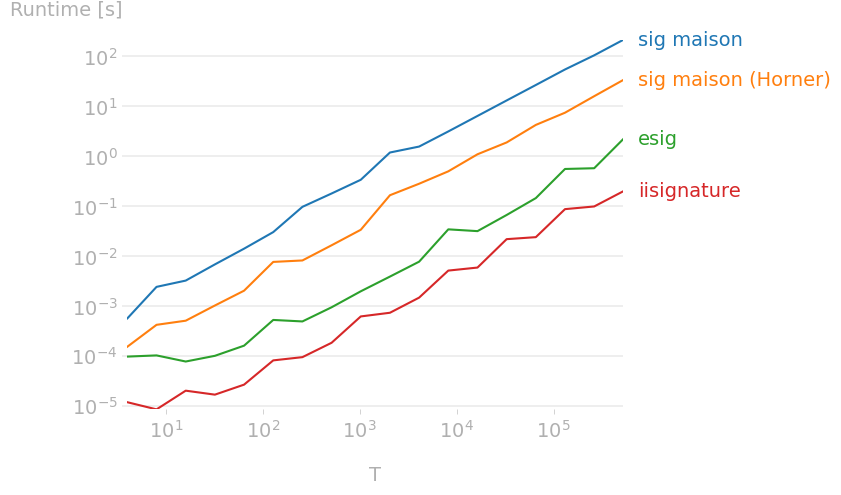

In [ ]:
perfplot.show(
    setup=lambda n: np.random.rand(n,10),
    kernels=[
        lambda X: sig(X,2),
        lambda X: sig_Horner(X,2),
        lambda X: ts.stream2sig(X,2),
        lambda X: iisig(X,2),
        #lambda X: np.append([1],np.array(signatory.signature(torch.from_numpy(X).unsqueeze(0),2).squeeze())),
    ],
    labels=["sig maison", "sig maison (Horner)", "esig", "iisignature"],
    n_range=[2**k for k in range(2,20)],
    xlabel="T",
)

Notre fonction signature maison est donc, en définitive :
- **correcte** : elle renvoie effectivement la signature du chemin en entrée
- **plus robuste qu'*esig*** : elle peut calculer la signature de plus de chemins qu'*esig*
- **un peu plus lente qu'*esig*** mais néanmoins **du même ordre de grandeur**

Mais elle est plus faible que *iisignature*, elle-même beaucoup moins puissante que *signatory* sur tous les tableaux.

# Utilisation des signatures

On cherche à construire un prédicteur $\hat Y(X)$ de $Y$ en fonction de $X$. Faisons simple et cherchons un régresseur linéaire.

In [ ]:
import statsmodels.api as sm

model_OLS  = sm.OLS( Y_train, X_train) #régression de Y par X
result_OLS = model_OLS.fit()
result_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 7.390e+04
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:10:59   Log-Likelihood:                -85326.
No. Observations:               58063   AIC:                         1.707e+05
Df Residuals:                   58030   BIC:                         1.710e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0355      0.766     14.405      0.000       9.534      12.537
x1             0.0005   6.06e-05      8.144      0.000       0.000       0.001
x2             0.0022   4.85e-05     45.850      0.000       0.002       0.002
x3             0.0019   2.05e-05     92.205      0.000       0.002       0.002
x4            -1.8982      0.350     -5.416      0.000      -2.585      -1.211
x5             1.5345      0.384      3.996      0.000       0.782       2.287
x6            -5.0538      0.265    -19.060      0.000      -5.574      -4.534
x7             5.8605      0.228     25.663      0.000       5.413       6.308
x8             4.1296      0.010    421.957      0.000       4.110       4.149
x9            -0.5333      0.012    -43.557      0.000      -0.557      -0.509
x10           -1.2430      0.104    -11.915      0.000      -1.447      -1.039
x11            1.1730      0.104     11.270      0.000       0.969       1.377
x12            0.0590      0.006     10.279      0.000       0.048       0.070
x13            0.1998      0.005     43.214      0.000       0.191       0.209
x14           -0.1123      0.011    -10.502      0.000      -0.133      -0.091
x15            0.1203      0.013      9.284      0.000       0.095       0.146
x16            0.2935      0.029     10.037      0.000       0.236       0.351
x17            0.0596      0.011      5.558      0.000       0.039       0.081
x18            1.0186      0.006    157.323      0.000       1.006       1.031
x19            0.2292      0.043      5.358      0.000       0.145       0.313
x20           -0.4733      0.019    -24.337      0.000      -0.511      -0.435
x21            2.2610      0.015    149.815      0.000       2.231       2.291
x22           -2.1983      0.035    -61.935      0.000      -2.268      -2.129
x23         -167.8596     21.407     -7.841      0.000    -209.817    -125.902
x24           -0.0038   9.48e-05    -39.723      0.000      -0.004      -0.004
x25           27.6557      0.380     72.823      0.000      26.911      28.400
x26           84.3051      1.489     56.622      0.000      81.387      87.223
x27           11.7103      0.741     15.799      0.000      10.258      13.163
x28            0.1276      0.002     70.416      0.000       0.124       0.131
x29           -0.2179      0.004    -60.558      0.000      -0.225      -0.211
x30            0.1529      0.006     23.566      0.000       0.140       0.166
x31            0.1815      0.015     12.298      0.000       0.153       0.210
x32            0.0085      0.001     12.755      0.000       0.007       0.010
==============================================================================
Omnibus:                     7828.575   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101757.255
Sk

In [ ]:
Y_hat_OLS = model_OLS.predict( result_OLS.params )
residual_OLS = Y_train - Y_hat_OLS

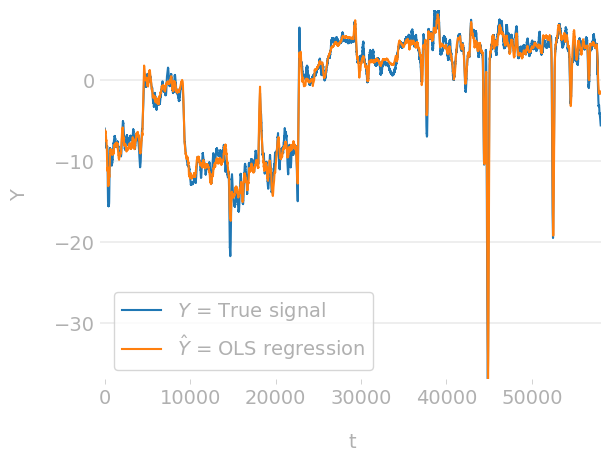

In [ ]:
plt.plot( Y_train  , label="$Y$ = True signal" )
plt.plot( Y_hat_OLS, label="$\hat{Y}$ = OLS regression" )
plt.xlabel('t')
plt.ylabel('Y')
plt.legend()
plt.show()

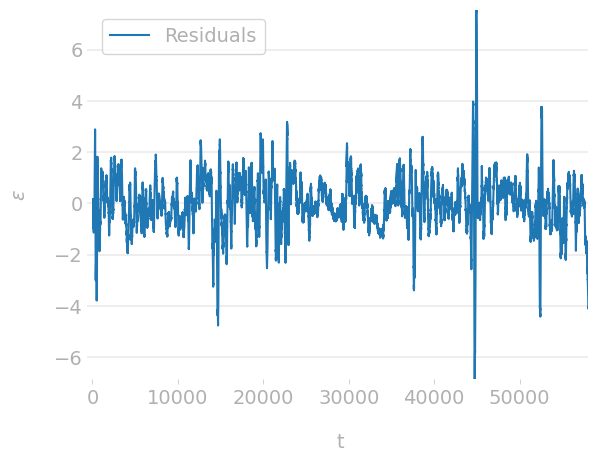

In [ ]:
plt.plot( residual_OLS  , label="Residuals" )
plt.xlabel('t')
plt.ylabel('$\epsilon$')
plt.legend()
plt.show()

Lorsque l'évolution de $Y$ dépend de celle de $X$ sous la forme d'une *équation différentielle contrôlée* $$dY_t = \ell(dX_t) Y_t,$$ avec $\ell$ linéaire, alors on peut généralement développer $Y$ en tant que série de la signature $S(X)$ :
$$Y_t = Y_s + \sum_{n\ge 0}\ell^{\otimes n} \big( S(X)^n_{s,t} \big). Y_s.$$

Ce théorème peut se généraliser grâce aux *chemins rugeux*. Essentiellement, la solution d'une ED contrôlée par $X$ est une fonction continue de $S(X)$ (et dans des cas simples, c'en est une combinaison liénaire). [cf. LYONS] \
Il est donc naturel d'adjoindre à la classe de nos régresseurs les différentes signatures.

## Rajout des signatures

In [ ]:
depth = 2

On rajoute pour tout $1\le t \le T$ un vecteur signature tronqué $S(X)_{t,t+h}^{depth}$ avec notre $h$ donné par l'autocorrélation.

In [ ]:
# Find signature sizes
window_data = np.zeros((h,d))
signatures  = isg.sig(window_data, depth)
sig_dim = signatures.shape[0]
print( "Dimension of signature features: ", sig_dim )

# Construct copies of data using moving window
sig_list = []
for i in range(T):
    if i<h:
        window_data = np.zeros( (h, d) )
    else:
        window_data = X_train[(i-h):i,:]
    signatures = isg.sig(window_data, depth)
    sig_list.append( signatures )

sig_array = np.array( sig_list)
print( "Dimension of output: ", sig_array.shape)

Dimension of signature features:  1122
Dimension of output:  (58063, 1122)


In [ ]:
# Fitting model

enhanced_X_train = np.append( X_train, sig_array, axis = 1) #on rajoute les colonnes signatures
print( enhanced_X_train.shape )
model_OLS_enhanced  = sm.OLS( Y_train, enhanced_X_train)
result = model_OLS_enhanced.fit()
result.summary()


(58063, 1155)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.776e+04
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:21:23   Log-Likelihood:                 21586.
No. Observations:               58063   AIC:                        -4.102e+04
Df Residuals:                   56985   BIC:                        -3.135e+04
Df Model:                        1077                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.1855      0.724     48.620      0.000      33.767      36.604
x1             0.0018   5.91e-05     30.473      0.000       0.002       0.002
x2             0.0025   4.48e-05     55.987      0.000       0.002       0.003
x3             0.0018   1.86e-05     96.438      0.000       0.002       0.002
x4            -3.6791      0.617     -5.963      0.000      -4.889      -2.470
x5             4.6139      0.702      6.575      0.000       3.238       5.989
x6             4.2167      4.600      0.917      0.359      -4.798      13.232
x7            -4.6803      4.605     -1.016      0.309     -13.706       4.346
x8             2.6991      0.068     39.579      0.000       2.565       2.833
x9             0.4938      0.029     17.118      0.000       0.437       0.550
x10           -3.7071      0.127    -29.117      0.000      -3.957      -3.458
x11            3.3778      0.128     26.360      0.000       3.127       3.629
x12            0.2049      0.006     32.054      0.000       0.192       0.217
x13            0.2287      0.007     32.845      0.000       0.215       0.242
x14           -0.2148      0.011    -19.010      0.000      -0.237      -0.193
x15            0.2388      0.018     13.425      0.000       0.204       0.274
x16            0.6684      0.026     25.277      0.000       0.617       0.720
x17           -0.6008      0.020    -30.087      0.000      -0.640      -0.562
x18            0.7387      0.006    125.900      0.000       0.727       0.750
x19            0.0913      0.076      1.209      0.227      -0.057       0.239
x20           -1.2493      0.018    -71.116      0.000      -1.284      -1.215
x21            1.5553      0.013    119.438      0.000       1.530       1.581
x22           -1.4796      0.031    -47.683      0.000      -1.540      -1.419
x23         -240.4844     18.274    -13.160      0.000    -276.302    -204.667
x24           -0.0017   8.57e-05    -20.181      0.000      -0.002      -0.002
x25           30.0639      0.352     85.326      0.000      29.373      30.754
x26           79.6700      1.814     43.912      0.000      76.114      83.226
x27           39.6573      0.867     45.765      0.000      37.959      41.356
x28            0.1041      0.002     44.557      0.000       0.100       0.109
x29           -0.6806      0.011    -59.445      0.000      -0.703      -0.658
x30           -0.6815      0.031    -21.641      0.000      -0.743      -0.620
x31           -0.2032      0.033     -6.175      0.000      -0.268      -0.139
x32           -0.0057      0.000    -11.725      0.000      -0.007      -0.005
x33           -0.6420      0.251     -2.553      0.011      -1.135      -0.149
x34           -0.0012   5.36e-05    -22.099      0.000      -0.001      -0.001
x35           -0.0061      0.000    -39.355      0.000      -0.006      -0.006
x3

In [ ]:
Y_hat_OLS_enhanced = model_OLS_enhanced.predict( result.params )

In [ ]:
residual_OLS_enhanced = Y_train-Y_hat_OLS_enhanced

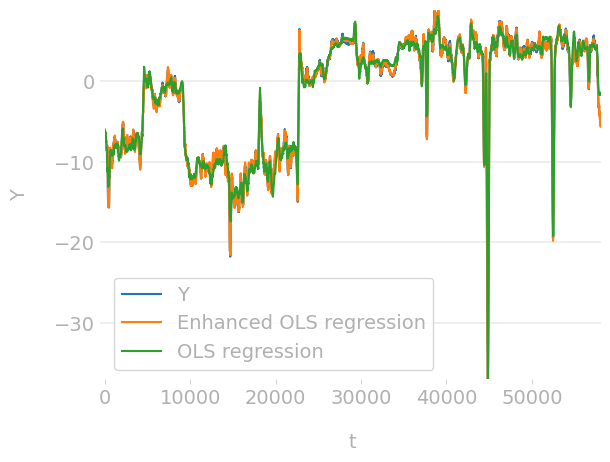

In [ ]:
plt.plot( Y_train  , label="Y" )
plt.plot( Y_hat_OLS_enhanced, label="Enhanced OLS regression" )
plt.plot( Y_hat_OLS, label="OLS regression" )
plt.xlabel('t')
plt.ylabel('Y')
plt.legend()
plt.show()

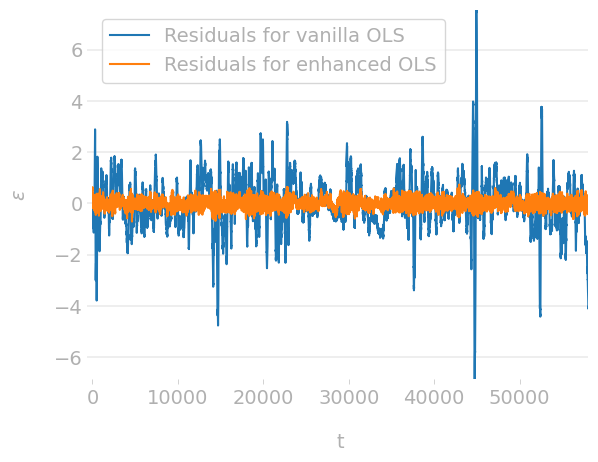

In [ ]:
plt.plot( residual_OLS           , label="Residuals for vanilla OLS" )
plt.plot( residual_OLS_enhanced  , label="Residuals for enhanced OLS" )
plt.xlabel('t')
plt.ylabel('$\epsilon$')
plt.legend()
plt.show()

## Rajout de bruit blanc

On pourrait se dire qu'il est mécanique d'avoir le $R^2$ qui augmente puisque l'on projette sur un espace beaucoup plus vaste. \
C'est vrai mais on n'a pas une telle augmentantion avec un bruit blanc.

In [ ]:
noise = np.random.normal(0, 1, (T,1122))
X_train_noised = np.concatenate( (X_train, noise), axis=1)


In [ ]:
model_OLS_noised  = sm.OLS( Y_train, X_train_noised)
result = model_OLS_noised.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2049.
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:39:15   Log-Likelihood:                -84773.
No. Observations:               58063   AIC:                         1.719e+05
Df Residuals:                   56908   BIC:                         1.822e+05
Df Model:                        1154                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2165      0.774     14.494      0.000       9.700      12.733
x1             0.0005   6.12e-05      7.897      0.000       0.000       0.001
x2             0.0022   4.91e-05     45.496      0.000       0.002       0.002
x3             0.0019   2.08e-05     91.313      0.000       0.002       0.002
x4            -1.8811      0.354     -5.313      0.000      -2.575      -1.187
x5             1.5171      0.388      3.911      0.000       0.757       2.277
x6            -5.0816      0.268    -18.973      0.000      -5.607      -4.557
x7             5.8869      0.231     25.521      0.000       5.435       6.339
x8             4.1287      0.010    417.240      0.000       4.109       4.148
x9            -0.5341      0.012    -43.197      0.000      -0.558      -0.510
x10           -1.2274      0.105    -11.658      0.000      -1.434      -1.021
x11            1.1580      0.105     11.024      0.000       0.952       1.364
x12            0.0596      0.006     10.272      0.000       0.048       0.071
x13            0.2001      0.005     42.838      0.000       0.191       0.209
x14           -0.1111      0.011    -10.284      0.000      -0.132      -0.090
x15            0.1200      0.013      9.172      0.000       0.094       0.146
x16            0.2925      0.030      9.910      0.000       0.235       0.350
x17            0.0573      0.011      5.292      0.000       0.036       0.079
x18            1.0172      0.007    155.555      0.000       1.004       1.030
x19            0.2266      0.043      5.245      0.000       0.142       0.311
x20           -0.4760      0.020    -24.216      0.000      -0.515      -0.437
x21            2.2591      0.015    148.131      0.000       2.229       2.289
x22           -2.1993      0.036    -61.332      0.000      -2.270      -2.129
x23         -166.3414     21.621     -7.694      0.000    -208.718    -123.965
x24           -0.0038   9.58e-05    -39.372      0.000      -0.004      -0.004
x25           27.7458      0.383     72.354      0.000      26.994      28.497
x26           84.0054      1.504     55.851      0.000      81.057      86.953
x27           11.5891      0.748     15.483      0.000      10.122      13.056
x28            0.1277      0.002     69.727      0.000       0.124       0.131
x29           -0.2180      0.004    -59.962      0.000      -0.225      -0.211
x30            0.1526      0.007     23.271      0.000       0.140       0.165
x31            0.1811      0.015     12.154      0.000       0.152       0.210
x32            0.0085      0.001     12.649      0.000       0.007       0.010
x33            0.0002      0.004      0.042      0.966      -0.008       0.009
x34            0.0009      0.004      0.197      0.844      -0.008       0.010
x35            0.0027      0.004      0.602      0.547      -0.006       0.011
x3

# Analyse de sensibilité

L'algèbre tensorielle est très volumineuse :
$$dim(T^{(n)}(\mathbb R^d)) = 1+d+d^2+\dots +d^n =\dfrac{d^{n+1}-1}{d-1}.$$
On veut donc faire de la réduction de dimension et calculer seulement les composantes les plus intéressantes de la signature. \
Or c'est extrêmement naturel car la signature vit dans la variété des *group-like* (sous-variété de l'algèbre tensorielle dont le redressement *les polynômes de Lie* est donné par le $\log$), de dimension beaucoup plus faible $$\sum_{0\le k \le n} \underbrace{\frac 1k\sum_{m|k} \mu(k/m) d^m }_{\le d^k}.$$
Il y a <u>beaucoup de redondance</u> dans le calcul des signatures.

## Analyse de la variance

On utilise des généralisations indices de Sobol pour déterminer quel facteur scalaire $X_i$ parmi les $X$ explique le plus par sa variation la variation de $Y$. $$S_i = \dfrac{\mathbb V(\mathbb E[Y|X_i])}{\mathbb V(Y)}$$  \
On sélectionne ainsi le meilleur régresseur par ANOVA (qui maximise l'indice de Sobol). Puis si l'on veut sélectionner le second meilleur, il faut procéder conditionnellement vu les fortes redondances. On sélectionne alors le régresseur qui maximise un indice de Sobol conditionnel.\
On va alors calculer l'indice de Chatterjee $$S(Y,X_{n+1}^*|X_1^*,\dots,X_n^*) : = \dfrac{\int_{-\infty}^{+\infty} \mathbb V(\mathbb E[1_{Y\ge t}|X_1^*,\dots,X_n^*]|X_{n+1}^*) d\mathbb P_Y(t)}{\int_{-\infty}^{+\infty} \mathbb V(1_{Y \ge t} | X_{n+1}^*) d\mathbb P_Y(t) }.$$

On a l'estimateur de rang non paramétrique de cet indice $$\hat T_m := \dfrac{\sum_{1\le i \le m}\min(Y_{M(i)},Y_i) - \min(Y_{N(i)},Y_i)}{\sum_{1 \le i \le m} Y_i - \min(Y_{N(i)},Y_i)},$$ où $M(i)$ désigne l'indice du plus proche voisin de $X^*_{n+1,i}$ parmi les $X_{n+1,j}^* ,j \neq i$, \
 et où $N(i)$ désigne l'indice du plus proche voisin de $(X_{1,i}^*,\dots,X_{n+1,i}^*)$ parmi les $(X_{1,j}^*,\dots,X_{n+1,j}^*), j \neq i$, \
 lorsque les $Y_i$ sont $m$ tirages indépendants de même loi (des vols supposés indépendants).

## FOCI Algorithm

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def sig_data(path, memory, depth_sig):

    print('shape of time considered during calcul of signatures :', memory)
    window_data=np.zeros( (memory, path.shape[1]) )

    shape_sig=0
    sig_list=[]
    for k in range(path.shape[0]):
        if k < memory:
            window_data=np.zeros( (memory, path.shape[1]) )
        else:
            window_data=path[k-memory:k,:]
        s=isg.prepare(path.shape[1], depth)
        signatures=isg.logsig( window_data, s )
        sig_list.append(np.array(signatures))

        shape_sig=signatures.shape[1]

    sig_array=np.array(sig_list)
    nan_indices = np.where( sig_array != sig_array )
    sig_array[nan_indices] = 0

    sig_array=sig_array.squeeze() #for reshape correctly our signatures

    print("lenght of one signature :",shape_sig)

    return sig_array

In [ ]:
def FOCI_function(X, y, memory, dele=None):

    delete = np.where(np.var( X, axis=0 ) == 0) ## deleting the zeros inputs
    if dele is not None:

        print("assume delete ",dele)
        print("instead of ",delete)

        delete = dele
    else:

        print("to be deleted:",delete)

    X = np.delete( X, delete, axis = 1)

    X_train_stand = (X - np.mean(X, axis=0))/np.var(X, axis = 0)
    Y_train_stand = (y[:,1] - np.mean(y[:,1], axis=0))/np.sqrt(np.var(y[:,1], axis = 0))

    X_iid = np.zeros((int(X.shape[0]/memory),X.shape[1]))
    Y_iid = np.zeros(int(y.shape[0]/memory))

    for k in range(int(X.shape[0]/memory)): ## we have with this shape 100x40 instead of 2000x40 with iid data
        X_iid[k,:] = X_train_stand[k*memory,:]
        Y_iid[k] = Y_train_stand[k*memory]


    Liste_principale = []
    value = []


    X_iid = np.append(X_iid, np.arange(X_iid.shape[1]).reshape(1,-1), axis=0) ## add a row of arange in our inputs
                                                                              ##  to simplify the code
    Z = X_iid #to keep the notation of the paper
    Y = Y_iid #same as above
    n = Z.shape[0] - 1 #number of rows into our model

    R = np.argsort(Y) #R define below
    L = n - R  #L define below


    T_list=np.zeros(Z.shape[1]) ## T_list is a list of the permutation N
    for i in range(Z.shape[1]):
        NN = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(Z[:-1,i].reshape(-1,1))

        # show the two nearest neighbors of each X in R^n, and take the good neighbor
        idx = NN.kneighbors(Z[:-1,i].reshape(-1,1))[1][:,1]

        ## Then, use the previous formula, when X = [], to implement the first iteration of FOCI algorithm :
        T_list[i] = np.sum(n*np.minimum(R,R[idx]) - L**2)/np.sum(L*(n-L))


    j_star = np.argmax(T_list) #j_star is the index where Tn as the highest value
    print("the argmax of all the estimator coefficient is ", j_star)
    print("This value is ",T_list[j_star])

    Liste_principale.append(j_star)
    value.append(T_list[j_star])

    Z2 = X_iid # On stocke la valeur de Z dans Z2

    X_=X_iid[:,j_star].reshape(-1,1) # X_ est l'input dont l'indice est j_star
    idx=j_star

    for l in range(Z2.shape[1]):

        X_ = np.concatenate((X_, Z[:,idx].reshape(-1,1)), axis=1) ## X_ is the conditionnal array in the formula
        X_iid = np.delete(X_iid, idx, axis = 1)  #the new Z, without Z[j_star]
        Z = X_iid  ## construct the new Z

        nn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(X_[:-1,:])
        N = nn.kneighbors(X_)[1][:-1,1]  # la permutation N de l'estimateur

        T_list=np.zeros(Z.shape[1])
        for i in range(Z.shape[1]):
            NN = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(Z[:-1,i].reshape(-1,1))

            M = NN.kneighbors(Z[:-1,i].reshape(-1,1))[1][:,1]  #la permutation M de l'estimateur

            T_list[i] = np.sum(np.minimum(R,R[M]) - np.minimum(R,R[N]))/np.sum(R-np.minimum(R,R[N]))
        if T_list.any() == np.zeros(Z.shape[1]).any():
            break

        idx = np.argmax(T_list)
        j_star = int(X_iid[-1, idx])

        Liste_principale = np.append(Liste_principale, j_star)
        value = np.append(value, T_list[idx])

    X_iid = np.delete(Z2, -1, axis=0) #On reconstruit X

    return Liste_principale, value, delete

In [ ]:
drop = 8

In [ ]:
sig_data_X = sig_data(X_train, 500, depth)

shape of time considered during calcul of signatures : 500


IndexError: ignored